# Named Entity Recognition task using RoBERTa
## test 3

In [ ]:
!pip install transformers datasets seqeval scikit-learn nlpaug evaluate -q

import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
from sklearn.utils.class_weight import compute_class_weight
from evaluate import load
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import nlpaug.augmenter.word as naw
import shap  # Per explainability
import random
!pip install nltk -q
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')


# Step 3: Function to load CoNLL file format
def load_conll_file(filepath):
    """
    Load a CoNLL file and extract sentences and their corresponding tags.

    Args:
        filepath (str): Path to the CoNLL file.

    Returns:
        tuple: A tuple containing lists of sentences and their respective tags.
    """
    sentences = []
    tags = []
    with open(filepath, "r") as file:
        sentence = []
        tag_sequence = []
        for line in file:
            line = line.strip()
            if not line:  # Fine frase
                if sentence:
                    sentences.append(sentence)
                    tags.append(tag_sequence)
                sentence = []
                tag_sequence = []
            else:
                token, tag = line.split()[:2]  # Token e Tag
                sentence.append(token)
                tag_sequence.append(tag)
        if sentence:  # Aggiungi l'ultima frase
            sentences.append(sentence)
            tags.append(tag_sequence)
    return sentences, tags


# Load training and testing datasets
train_sentences, train_tags = load_conll_file("/content/re3d-train.conll")
test_sentences, test_tags = load_conll_file("/content/re3d-test.conll")


# Preparing the dataset
unique_tags = sorted(set(tag for tags in train_tags for tag in tags))
tag2id = {tag: i for i, tag in enumerate(unique_tags)}
id2tag = {i: tag for tag, i in tag2id.items()}


def encode_tags(tags, tag2id):
    """
    Encode tags into numerical IDs.

    Args:
        tags (list): List of tags for sentences.
        tag2id (dict): Mapping from tag to ID.

    Returns:
        list: Encoded tags as numerical IDs.
    """
    return [[tag2id[tag] for tag in sentence_tags] for sentence_tags in tags]


# Encode tags for training and testing datasets
train_tag_ids = encode_tags(train_tags, tag2id)
test_tag_ids = encode_tags(test_tags, tag2id)


# Transform data into Dataset format
train_data = [{"tokens": tokens, "tags": tags} for tokens, tags in zip(train_sentences, train_tag_ids)]
test_data = [{"tokens": tokens, "tags": tags} for tokens, tags in zip(test_sentences, test_tag_ids)]

dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "test": Dataset.from_list(test_data),
})


# Data Augmentation
def augment_data(dataset, target_label, n_augment=5):
    """
    Augment data using synonym replacement for a specific label.

    Args:
        dataset (list): Dataset to augment.
        target_label (int): Label ID to target for augmentation.
        n_augment (int): Number of augmentations to generate per example.

    Returns:
        list: Augmented dataset.
    """
    aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.3) # Initialize synonym augmenter
    augmented_data = []
    for example in dataset:
        if target_label in example["tags"]: # Target examples containing the label
            for _ in range(n_augment):
                augmented_text = aug.augment(example["tokens"]) # Apply augmentation
                augmented_data.append({
                    "tokens": augmented_text,
                    "tags": example["tags"]
                })
    return augmented_data


# Perform data augmentation for low-frequency labels
low_freq_labels = ["B-MilitaryPlatform", "B-Nationality", "B-Weapon"]
augmented_train = []
for label in low_freq_labels:
    augmented_train += augment_data(train_data, tag2id[label], n_augment=5)

train_data += augmented_train
dataset["train"] = Dataset.from_list(train_data)


# Tokenization and alignment of labels
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)


def tokenize_and_align_labels(examples):
    """
    Tokenize input sentences and align labels to tokenized words.

    Args:
        examples (dict): Input examples with tokens and tags.

    Returns:
        dict: Tokenized inputs with aligned labels.
    """
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True, padding="max_length", max_length=128
    )
    labels = []
    for i, label in enumerate(examples["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_id = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)  # Ignore padding
            elif word_id != previous_word_id:  # First token of the word
                label_ids.append(label[word_id])
            else:  # Additional tokens of the same word
                label_ids.append(-100)
            previous_word_id = word_id
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Map tokenization function to the dataset
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)


# Compute class weights for loss balancing
labels = [tag for tags in train_tag_ids for tag in tags]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)


# Define the model and training parameters
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(unique_tags))
model.config.id2label = id2tag
model.config.label2id = tag2id


# Define Focal Loss
class FocalLoss(nn.Module):
    """
    Focal Loss for handling class imbalance in token classification tasks.

    Args:
        alpha (torch.Tensor): Class weights for balancing.
        gamma (float): Focusing parameter to reduce loss contribution from easy examples.
        ignore_index (int): Index to ignore in the loss computation.
    """
    def __init__(self, alpha=None, gamma=2, ignore_index=-100):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index

    def forward(self, logits, labels):
         """
        Compute Focal Loss.

        Args:
            logits (torch.Tensor): Model predictions.
            labels (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: Computed focal loss.
        """
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, ignore_index=self.ignore_index)(logits.view(-1, logits.size(-1)), labels.view(-1))
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()


# Define evaluation metric
metric = load("seqeval")

def compute_metrics(eval_pred):
    """
    Compute evaluation metrics using seqeval.

    Args:
        eval_pred (tuple): Predictions and labels from the model.

    Returns:
        dict: Evaluation metrics (precision, recall, F1, accuracy).
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[id2tag[label] for label in sentence if label != -100] for sentence in labels]
    true_predictions = [[id2tag[pred] for pred, label in zip(sentence, labels[i]) if label != -100]
                        for i, sentence in enumerate(predictions)]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


# Define a custom trainer with Focal Loss
class CustomTrainer(Trainer):
    """
    Custom Trainer class to use Focal Loss for token classification.
    """
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Override compute_loss to use Focal Loss.

        Args:
            model (torch.nn.Module): Model being trained.
            inputs (dict): Input data with labels.
            return_outputs (bool): Whether to return model outputs with loss.

        Returns:
            torch.Tensor: Computed loss or loss and outputs.
        """
        focal_loss = FocalLoss(alpha=class_weights.to(model.device), gamma=2)  # Create an instance of FocalLoss
        outputs = model(**inputs)  # Get model outputs
        logits = outputs.logits  # Extract logits
        labels = inputs.get("labels")  # Extract ground truth labels
        loss = focal_loss(logits, labels)  # Compute Focal Loss
        return (loss, outputs) if return_outputs else loss


# Initialize the trainer
trainer = CustomTrainer(
    model=model,
    args=TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=10,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        save_strategy="epoch",
        fp16=True,
    ),
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=None
)

# Train the model
trainer.train()

# Final evaluation
results = trainer.evaluate()
print(results)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Map:   0%|          | 0/1350 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-949aaca5e61d>:177: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer( # Use CustomTrainer instead of Trainer


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.035500,1.377046,0.043672,0.232249,0.073519,0.277482
2,0.132800,0.376975,0.152712,0.474852,0.231102,0.602701
3,0.049900,0.187358,0.270169,0.639053,0.379780,0.712058
4,0.009300,0.133603,0.341074,0.695266,0.457644,0.759985
5,0.011800,0.148938,0.337419,0.692308,0.453708,0.758653
6,0.003700,0.160188,0.378508,0.698225,0.490900,0.777862
7,0.002700,0.164683,0.375594,0.701183,0.489164,0.779764
8,0.004100,0.154444,0.381703,0.715976,0.497942,0.786040
9,0.002600,0.156974,0.397858,0.714497,0.511111,0.791175
10,0.001600,0.160193,0.394737,0.710059,0.507400,0.790795


{'eval_loss': 0.15697430074214935, 'eval_precision': 0.3978583196046129, 'eval_recall': 0.7144970414201184, 'eval_f1': 0.5111111111111112, 'eval_accuracy': 0.7911753518448079, 'eval_runtime': 0.6156, 'eval_samples_per_second': 324.908, 'eval_steps_per_second': 21.119, 'epoch': 10.0}


Classification Report:
                     precision    recall  f1-score   support

B-DocumentReference       0.15      1.00      0.26         8
         B-Location       0.58      0.87      0.70       155
 B-MilitaryPlatform       0.26      0.56      0.36        16
            B-Money       0.17      1.00      0.30         4
      B-Nationality       0.26      0.60      0.36        10
     B-Organisation       0.62      0.84      0.71       284
           B-Person       0.78      0.95      0.86       106
         B-Quantity       0.51      0.97      0.67        30
         B-Temporal       0.43      0.91      0.59        46
           B-Weapon       0.16      0.88      0.28        17
I-DocumentReference       0.37      0.95      0.54        20
         I-Location       0.53      0.93      0.68       191
 I-MilitaryPlatform       0.53      0.88      0.67        26
            I-Money       0.35      0.78      0.48         9
      I-Nationality       0.00      0.00      0.00         2


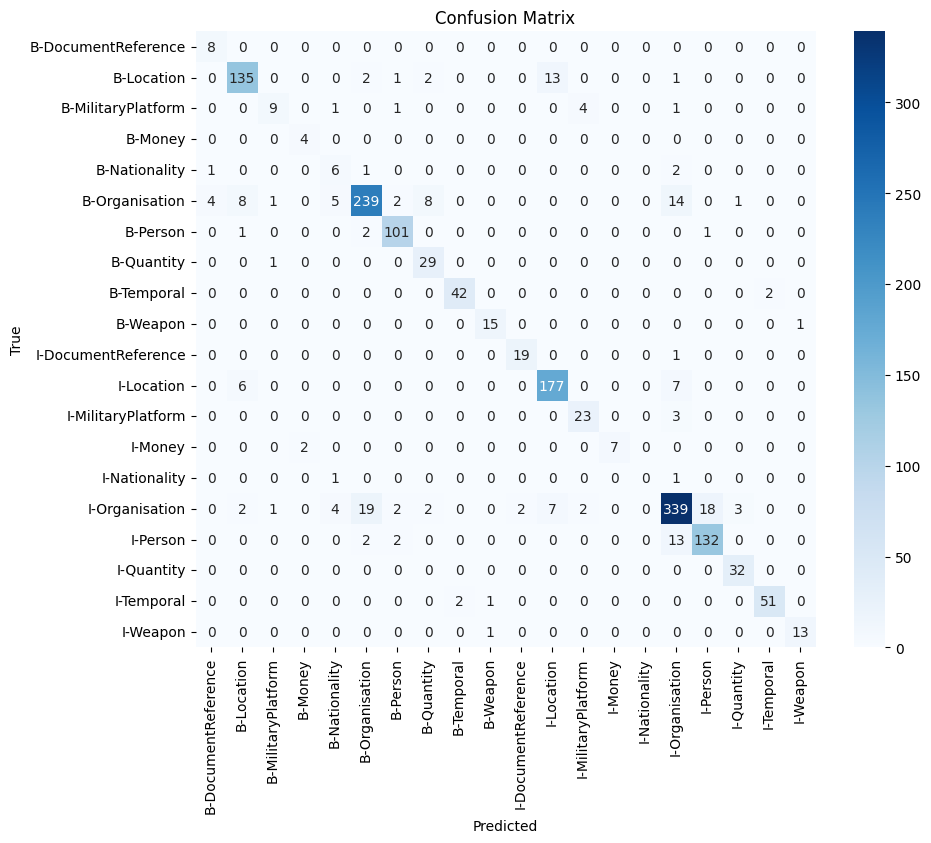

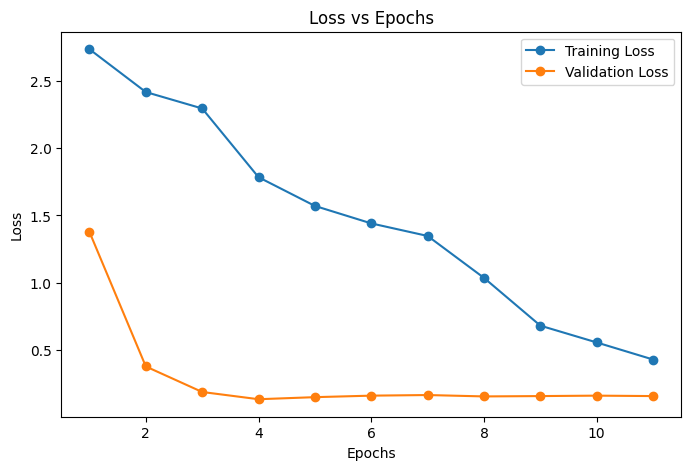

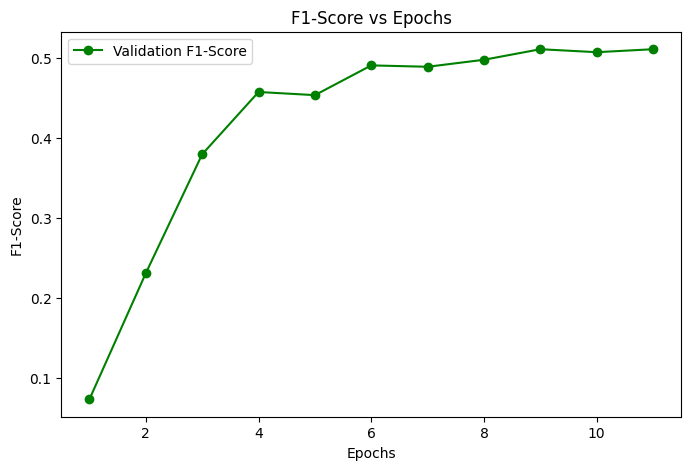

In [ ]:
# Step 15: Visualization of results
def generate_classification_report(trainer, dataset, id2tag):
    """
    Generate a classification report for the test dataset, including precision, recall, and F1-score.

    Args:
        trainer (Trainer): The trained model's trainer object.
        dataset (Dataset): The dataset for evaluation.
        id2tag (dict): Mapping from tag IDs to tag labels.

    Returns:
        y_true (list): List of true labels for the dataset.
        y_pred (list): List of predicted labels for the dataset.
    """
    # Obtain predictions and true labels
    predictions, labels, _ = trainer.predict(dataset)
    predictions = np.argmax(predictions, axis=2)

    # Convert tag IDs to their corresponding labels, ignoring padding tokens
    true_labels = [[id2tag[label] for label in sentence if label != -100] for sentence in labels]
    true_predictions = [[id2tag[pred] for pred, label in zip(sentence, labels[i]) if label != -100]
                        for i, sentence in enumerate(predictions)]

    # Flatten lists for computing the classification report
    y_true = [label for sentence in true_labels for label in sentence]
    y_pred = [pred for sentence in true_predictions for pred in sentence]

    # Print and return the classification report
    report = classification_report(y_true, y_pred, labels=list(id2tag.values()), zero_division=0)
    print("Classification Report:")
    print(report)
    return y_true, y_pred


def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plot the confusion matrix for the predictions on the test dataset.

    Args:
        y_true (list): True labels for the dataset.
        y_pred (list): Predicted labels for the dataset.
        classes (list): List of class labels to include in the confusion matrix.
    """
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


def plot_training_metrics(log_history):
    """
    Plot training metrics, including loss and F1-score, for each epoch.

    Args:
        log_history (list): Log history from the trainer object, containing loss and evaluation metrics.
    """
    # Extract training loss, evaluation loss, and F1-score
    train_loss = [entry["loss"] for entry in log_history if "loss" in entry]
    eval_loss = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]
    eval_f1 = [entry["eval_f1"] for entry in log_history if "eval_f1" in entry]

    # Define epochs based on the length of the evaluation loss array
    epochs = range(1, len(eval_loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss[:len(eval_loss)], label="Training Loss", marker="o")  # Truncate train_loss to match eval_loss
    plt.plot(epochs, eval_loss, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.show()

    # Plot validation F1-score
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, eval_f1, label="Validation F1-Score", marker="o", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("F1-Score")
    plt.title("F1-Score vs Epochs")
    plt.legend()
    plt.show()


# Generate classification report and plot confusion matrix
y_true, y_pred = generate_classification_report(trainer, tokenized_datasets["test"], id2tag)
classes = [tag for tag in unique_tags if tag != "O"]
plot_confusion_matrix(y_true, y_pred, classes)

# Plot training metrics (loss and F1-score)
plot_training_metrics(trainer.state.log_history)
